In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
user = str(input('Quem está usando? '))

Quem está usando? livia


In [3]:
import os
if user.upper() == 'LIVIA':
  if os.getcwd() == '/content':
    os.chdir('drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere')
    print(os.getcwd())
    print(os.listdir())
  elif os.getcwd() == '/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere':
    print(os.getcwd())
    print(os.listdir())

/content/drive/.shortcut-targets-by-id/1euz72zyBHQsYylI2a3XEEAGw_g9D3qlJ/CNPQ_MUD_CLIMA/Artigo_Atmosphere
['referências', 'resultados', 'Figuras', 'indices_clima_merged_1981-2023_out-abril.csv', 'planilhas', 'analises_artigo.ipynb', 'shapes', 'indices_clima_merged_1981-2023_out-abril.gsheet', 'correlogram_analysis.ipynb', 'df_correlogram.xlsx', 'merged_indices_vf3_correlogram.csv', 'figuras_area_estudo_dados_artigo.ipynb']


#### Carregando bibliotecas

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import networkx as nx
import statsmodels.api as sm
import plotly.express as px
!pip install pymannkendall
import pymannkendall as mk
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import kendalltau
from pymannkendall import original_test
!pip install cartopy
from cartopy import crs as ccrs, feature as cfeature
import geopandas as gpd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 93.6 MB/s eta 0:00:00


#### Abrindo arquivo .csv

In [5]:
# Caminho do arquivo CSV
file_path = '/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/indices_clima_merged_1981-2023_out-abril.csv'

# Carregando DataFrame
df = pd.read_csv(file_path, delimiter=',')

# Convertendo 'time' para datetime e definindo como índice
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Limpando a coluna de nomes
df.columns = df.columns.str.strip()
df

,AO,AMM,AMO,ATSST,BEST,CAR,CIP,EA_WR,EPI,EP_NP,...,SPI6_Cerrado,SPI6_Mata Atlantica,SPI6_Caatinga,SPI6_Pampa,SPI12_Amazonia,SPI12_Pantanal,SPI12_Cerrado,SPI12_Mata Atlantica,SPI12_Caatinga,SPI12_Pampa
time,,,,,,,,,,,,,,,,,,,,,
1981-01-01,-0.116,1.72,-0.189,0.307,-0.31,-0.14,103.0,0.11,-0.59035,1.02,...,0.560264,0.198903,-0.169154,-0.028721,-0.443858,0.719208,0.735646,0.169485,-0.058996,0.152609
1981-02-01,-0.332,2.78,-0.188,0.154,-0.03,-0.13,8.0,-1.13,0.38788,-0.03,...,-0.067606,-0.086074,-0.710128,0.442346,-0.562161,0.417538,-0.495411,-0.170494,-1.424401,0.416807
1981-03-01,-1.645,5.09,-0.007,1.124,0.82,-0.10,120.0,0.90,0.81679,0.03,...,0.206004,-0.044584,0.623428,0.473861,-0.679338,0.590223,0.229004,0.084782,-0.085384,-0.090331
1981-04-01,0.430,4.03,-0.103,0.501,0.18,-0.10,27.0,1.37,0.71754,-0.19,...,0.237764,0.151643,0.449238,-0.028749,-0.749129,0.532562,0.052104,0.067001,0.076559,-0.213990
1981-10-01,-1.167,-0.90,-0.194,-0.147,0.32,-0.16,342.0,-2.08,-0.57056,-0.01,...,0.158852,-0.458237,-1.004214,-1.133636,-0.763607,0.653092,0.264107,-0.260659,0.100911,-0.764125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,0.280,1.02,NaN,NaN,-0.15,NaN,NaN,1.99,-0.50327,0.39,...,0.158589,0.606244,0.685068,-1.639125,0.307507,0.094885,-0.091385,0.601789,0.643621,-0.936100
2023-04-01,-0.973,1.12,NaN,NaN,0.12,NaN,NaN,-0.22,-0.14821,-0.67,...,0.285663,0.621780,0.554926,-1.821790,0.316293,0.418269,0.107707,0.656667,0.645254,-1.510657
2023-10-01,-0.414,5.51,NaN,NaN,-9.99,NaN,NaN,0.61,1.31229,0.31,...,-0.490825,0.334470,-0.190880,1.695539,-0.030967,-0.204915,0.036830,0.739552,0.372502,0.220505


### Figuras período dos dados

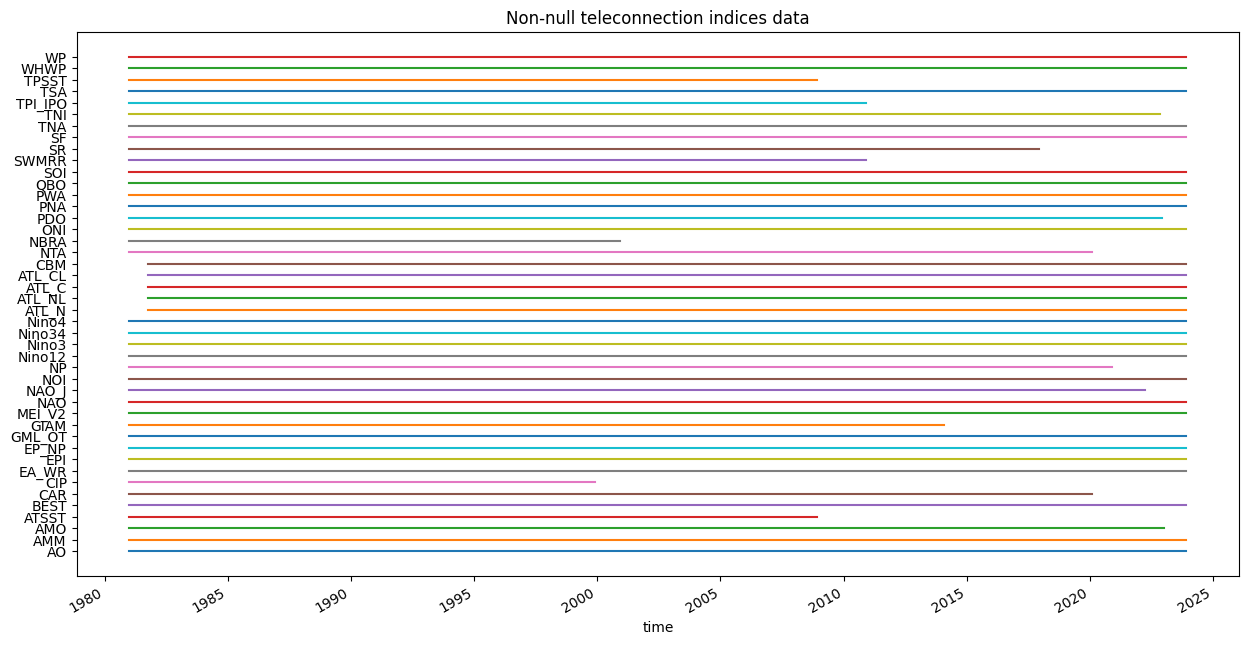

In [ ]:
df.columns[0:45]
# Plotar linha continua reta para dados não nulos e deixar em branco para dados nulos

# Selecionando apenas as colunas de interesse
linha = df.iloc[:, :44].copy()

# Criando um mapeamento para os valores não nulos
for i, col in enumerate(linha.columns):
    linha[col] = linha[col].where(linha[col].isnull(), i)

# Plotar linha contínua para dados não nulos de cada variável

fig, ax = plt.subplots(figsize = (15, 8))

linha.plot(ax = ax, legend = False)

# Definir labels em y como as variáveis e estação
ax.set_yticks(range(len(linha.columns)))
ax.set_yticklabels([f'{estacao}' for estacao in linha.columns])

# Definir título
ax.set_title('Non-null teleconnection indices data')

# Define output directory
output_dir = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras"
os.makedirs(output_dir, exist_ok=True)

filename = f"{output_dir}/non-null_data_teleconnections.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")


### Figuras período dos dados v2

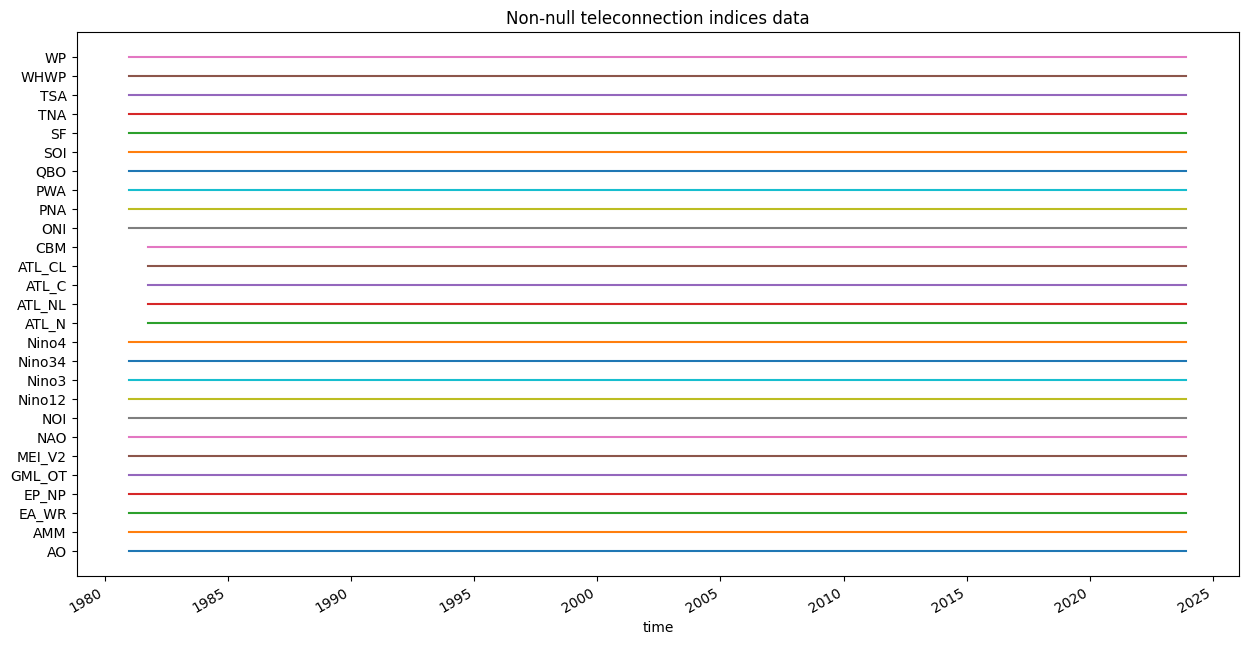

In [ ]:
df.columns[0:45]
# Plotar linha continua reta para dados não nulos e deixar em branco para dados nulos

# Selecionando apenas as colunas de interesse
linha = df.iloc[:, :44].copy()

linha = linha.drop(columns=['AMO', 'ATSST', 'BEST', 'CAR', 'CIP', 'EPI', 'GIAM',
                            'NAO_J', 'NP', 'NTA', 'NBRA', 'PDO', 'SWMRR', 'SR',
                            'TNI', 'TPI_IPO', 'TPSST'])

# Criando um mapeamento para os valores não nulos
for i, col in enumerate(linha.columns):
    linha[col] = linha[col].where(linha[col].isnull(), i)

# Plotar linha contínua para dados não nulos de cada variável

fig, ax = plt.subplots(figsize = (15, 8))

linha.plot(ax = ax, legend = False)

# Definir labels em y como as variáveis e estação
ax.set_yticks(range(len(linha.columns)))
ax.set_yticklabels([f'{estacao}' for estacao in linha.columns])

# Definir título
ax.set_title('Non-null teleconnection indices data')

# Define output directory
output_dir = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras"
os.makedirs(output_dir, exist_ok=True)

filename = f"{output_dir}/non-null_data_teleconnections_v2.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")


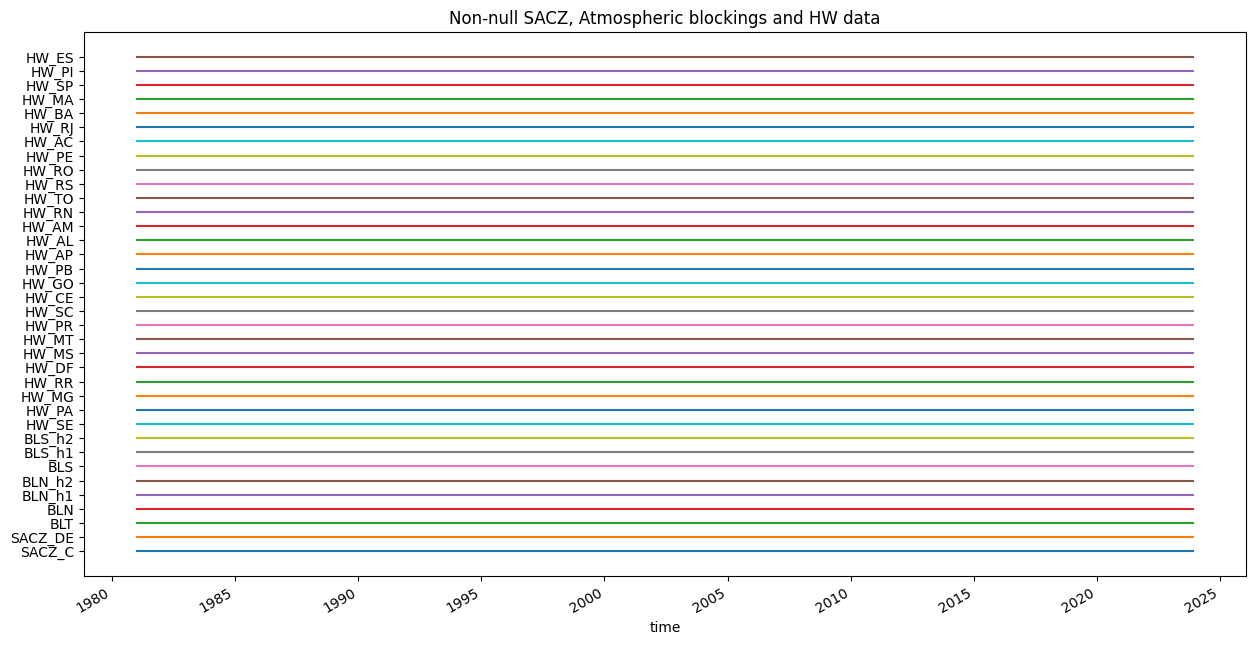

In [ ]:
df.columns[45:81]
# Plotar linha continua reta para dados não nulos e deixar em branco para dados nulos

# Selecionando apenas as colunas de interesse
linha = df.iloc[:, 45:81].copy()

# Criando um mapeamento para os valores não nulos
for i, col in enumerate(linha.columns):
    linha[col] = linha[col].where(linha[col].isnull(), i)

# Plotar linha contínua para dados não nulos de cada variável

fig, ax = plt.subplots(figsize = (15, 8))

linha.plot(ax = ax, legend = False)

# Definir labels em y como as variáveis e estação
ax.set_yticks(range(len(linha.columns)))
ax.set_yticklabels([f'{estacao}' for estacao in linha.columns])

# Definir título
ax.set_title('Non-null SACZ, Atmospheric blockings and HW data')

# Define output directory
output_dir = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras"
os.makedirs(output_dir, exist_ok=True)

filename = f"{output_dir}/non-null_data_sacz_block_hw.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")

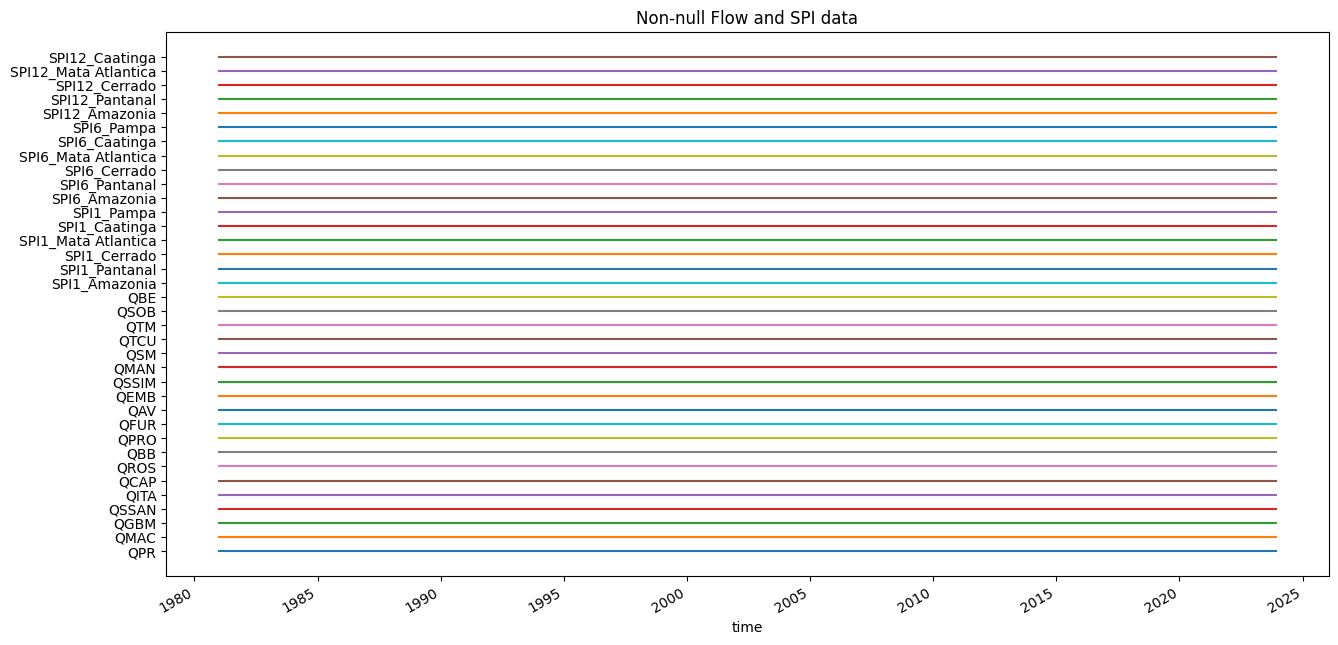

In [ ]:
df.columns[81:-1]
# Plotar linha continua reta para dados não nulos e deixar em branco para dados nulos

# Selecionando apenas as colunas de interesse
linha = df.iloc[:, 81:-1].copy()

# Criando um mapeamento para os valores não nulos
for i, col in enumerate(linha.columns):
    linha[col] = linha[col].where(linha[col].isnull(), i)

# Plotar linha contínua para dados não nulos de cada variável

fig, ax = plt.subplots(figsize = (15, 8))

linha.plot(ax = ax, legend = False)

# Definir labels em y como as variáveis e estação
ax.set_yticks(range(len(linha.columns)))
ax.set_yticklabels([f'{estacao}' for estacao in linha.columns])

# Definir título
ax.set_title('Non-null Flow and SPI data')

# Define output directory
output_dir = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras"
os.makedirs(output_dir, exist_ok=True)

filename = f"{output_dir}/non-null_data_flow_spi.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [7]:
# ==========================
# Carregamento do Shapefile do Brasil
# ==========================
brasil = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/mapas_perigo/dados/shape_br/BR_UF_2021.shp")
brasil = brasil.to_crs(epsg=4326)

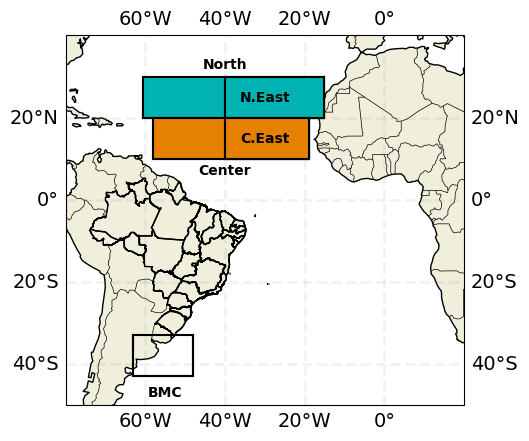

In [9]:
# projPC = ccrs.PlateCarree(central_longitude=180)
# lonW = 50
# lonE = 180
# latS = -50
# latN = 45
# cLat = (latN + latS) / 2
# cLon = (lonW + lonE) / 2
# res = '110m'


projPC = ccrs.PlateCarree(central_longitude=0)
lonW = -80
lonE = 20
latS = -50
latN = 40
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

# create a figure
fig = plt.figure()

# assign axis and define the projection
ax = plt.subplot(1, 1, 1, projection=projPC)

gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--'
)

ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.coastlines(resolution=res, color='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black');
# ax.add_feature(cfeature.LAND, color=[.7, .7, .7])
ax.add_feature(cfeature.LAND)

gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# Define SST regions with color and label positions
# (max_lon, max_lat), (max_lon, min_lat), (min_lon, min_lat), (min_lon, max_lat)
regions = {
    # 'Niño 1+2': [(-90, 0), (-90, -10), (-80, -10), (-80, 0)],
    # 'Niño 3': [(-150, 5), (-150, -5), (-90, -5), (-90, 5)],
    # 'Niño 4': [(160 - 360, 5), (160 - 360, -5), (210 - 360, -5), (210 - 360, 5)],
    # 'Niño 3.4': [(-170, 5), (-170, -5), (-120, -5), (-120, 5)],
    'North': [(344.9 - 360, 30), (344.9 - 360, 20), (299.45 - 360, 20), (299.45 - 360, 30)],
    'N.East': [(344.9 - 360, 30), (344.9 - 360, 20), (320 - 360, 20), (320 - 360, 30)],
    'Center': [(341 - 360, 20), (341 - 360, 10), (302 - 360, 10), (302 - 360, 20)],
    'C.East': [(341 - 360, 20), (341 - 360, 10), (320 - 360, 10), (320 - 360, 20)],
    'BMC': [(312 - 360, -33), (312 - 360, -43), (297 - 360, -43), (297 - 360, -33)],
}
edgecolors = {
    # 'Niño 1+2': 'black',
    # 'Niño 3': [.7, .7, .7],
    # 'Niño 4': [.7, .7, .7],
    # 'Niño 3.4': 'black',
    'North': 'black',
    'N.East': 'black',
    'Center': 'black',
    'C.East': 'black',
    'BMC': 'black',
}
colors = {
    # 'Niño 1+2': 'none',
    # 'Niño 3': [1, .4, .4],
    # 'Niño 4': [.4, .6, 1],
    # 'Niño 3.4': 'none',
    'North': [0, 179/255, 179/255],
    'N.East': [0, 179/255, 179/255],
    'Center': [230/255, 128/255, 0],
    'C.East': [230/255, 128/255, 0],
    'BMC': 'none',
}
labels = {
    # 'Niño 1+2': (-90, -13.5),
    # 'Niño 3': (-105, 0),
    # 'Niño 4': (-188, 0),
    # 'Niño 3.4': (-147, 8),
    'North': (320 - 360, 33),
    'N.East': (330 - 360, 25),
    'Center': (320 - 360, 7),
    'C.East': (330 - 360, 15),
    'BMC': (305 - 360, -47),
}
order = {
    # 'Niño 1+2': 10,
    # 'Niño 3': 8,
    # 'Niño 4': 8,
    # 'Niño 3.4': 10,
    'North': 8,
    'N.East': 10,
    'Center': 8,
    'C.East': 10,
    'BMC': 8
}


# Plot regions
for name, region in regions.items():
    lons, lats = zip(*region)
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), color=edgecolors[name], linewidth=1.5, zorder = order[name])
    ax.fill(lons, lats, color=colors[name], edgecolor=edgecolors[name], linewidth=1.5, zorder = order[name], transform=ccrs.PlateCarree())
    ax.text(*labels[name], name, horizontalalignment='center', verticalalignment='center', fontsize=10, fontweight='bold', color='black', zorder = 12, transform=ccrs.PlateCarree())

# Shapefile do Brasil
brasil.plot(ax=ax, facecolor="none", edgecolor="black", zorder = 10)


# # Capitais do Brasil para ondas de calor
# lons_hw = [-49.266873, -51.121873, -48.548900, -40.375220, -43.966878, -43.391120, -46.637177, -67.827020, -51.093464, -59.983923,
#            -48.456545, -63.869757, -60.703580, -48.322951, -49.262223, -56.091689, -54.616175, -35.724432, -38.484514, -38.556329,
#             -44.259858, -34.862597, -34.942075, -42.79097, -35.25804, -37.087555, -47.89463]
# lats_hw = [-25.434657, -29.973011, -27.594514, -20.342443, -19.914189, -22.864019, -23.560714, -9.970123, 0.032312, -3.067863, -1.435312,
#            -8.766493, 2.820423, -10.223291, -16.685239, -15.597807, -20.461428, -9.647983, -12.984535, -3.780144, -2.548971, -7.150461,
#             -8.048461, -5.087195, -5.757555, -10.90724, -15.800849]

# ax.plot(lons_hw, lats_hw, transform=ccrs.PlateCarree(), ls = 'dotted', color = 'red', zorder = 10)


# Define output directory
output_dir = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras"
os.makedirs(output_dir, exist_ok=True)

filename = f"{output_dir}/map_sst_atl.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")

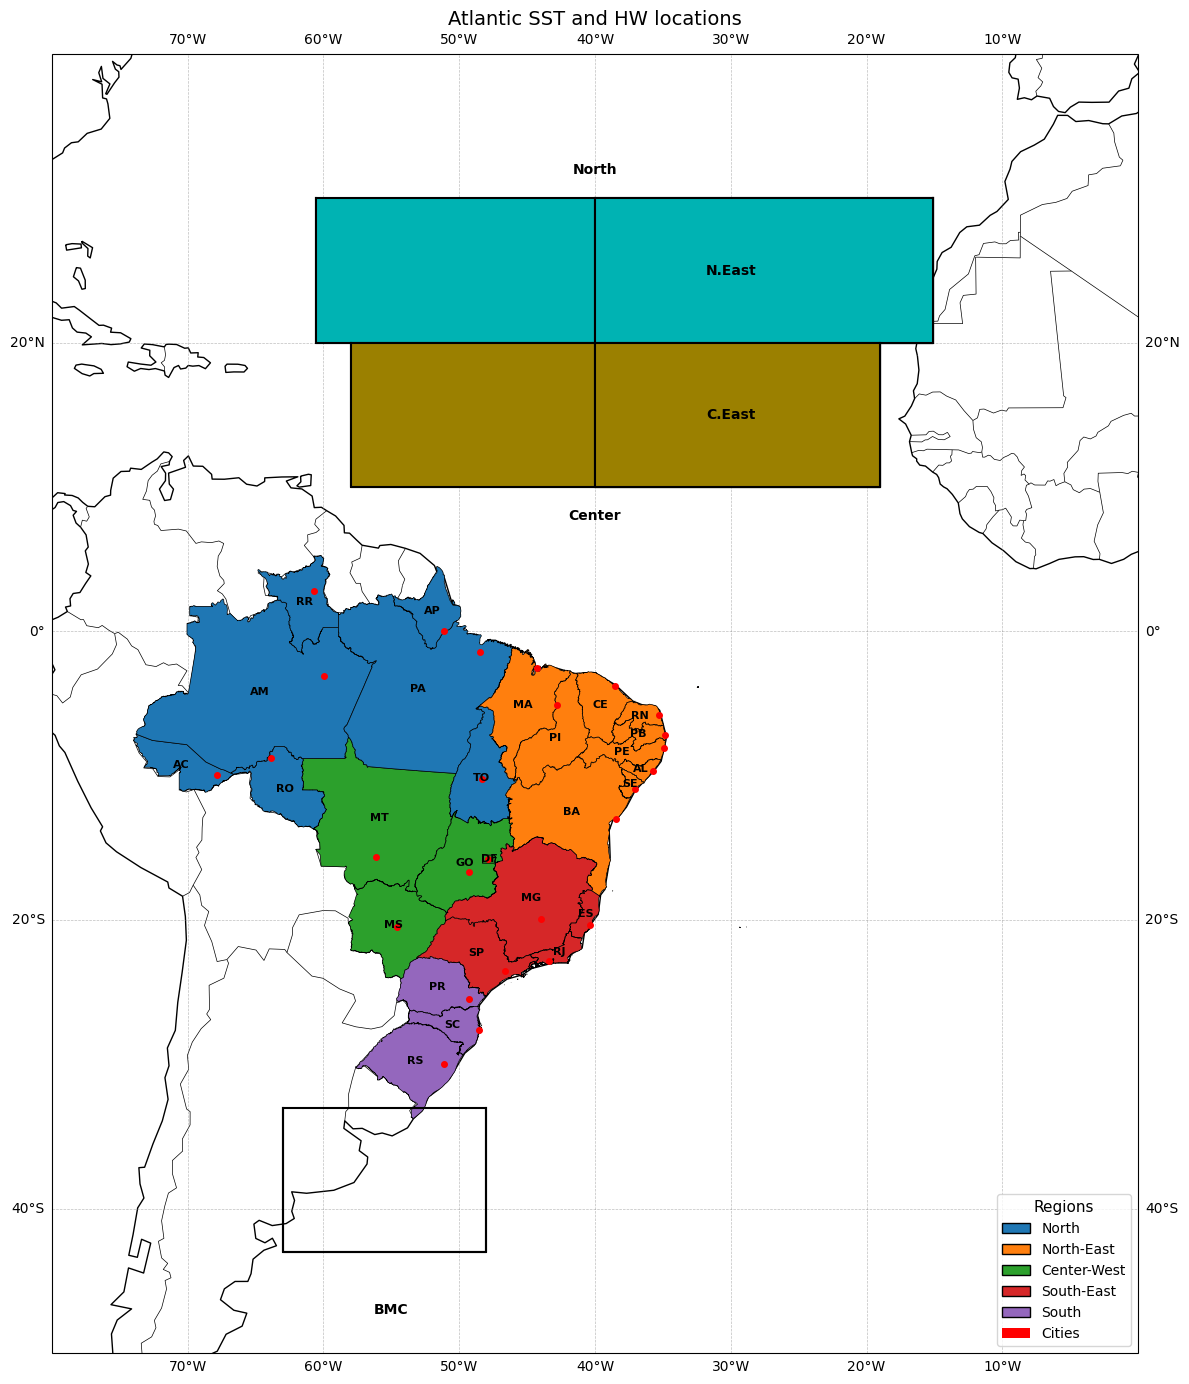

In [ ]:
# --- PROJEÇÃO E MAPA BASE ---
projPC = ccrs.PlateCarree(central_longitude=0)
lonW = -80
lonE = 0
latS = -50
latN = 40
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

fig = plt.figure(figsize=(12,20))
ax = plt.subplot(1,1,1, projection=projPC)

ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.coastlines(resolution='110m', color='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, color='white', edgecolor='black')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# Define SST regions with color and label positions
# (max_lon, max_lat), (max_lon, min_lat), (min_lon, min_lat), (min_lon, max_lat)
regions = {
    'North': [(344.9 - 360, 30), (344.9 - 360, 20), (299.45 - 360, 20), (299.45 - 360, 30)],
    'N.East': [(344.9 - 360, 30), (344.9 - 360, 20), (320 - 360, 20), (320 - 360, 30)],
    'Center': [(341 - 360, 20), (341 - 360, 10), (302 - 360, 10), (302 - 360, 20)],
    'C.East': [(341 - 360, 20), (341 - 360, 10), (320 - 360, 10), (320 - 360, 20)],
    'BMC': [(312 - 360, -33), (312 - 360, -43), (297 - 360, -43), (297 - 360, -33)],
}
edgecolors = {
    'North': 'black',
    'N.East': 'black',
    'Center': 'black',
    'C.East': 'black',
    'BMC': 'black',
}
colors = {
    'North': [0, 179/255, 179/255],
    'N.East': [0, 179/255, 179/255],
    'Center': [155/255, 128/255, 0],
    'C.East': [155/255, 128/255, 0],
    'BMC': 'none',
}
labels = {
    'North': (320 - 360, 32),
    'N.East': (330 - 360, 25),
    'Center': (320 - 360, 8),
    'C.East': (330 - 360, 15),
    'BMC': (305 - 360, -47),
}
order = {
    'North': 8,
    'N.East': 10,
    'Center': 8,
    'C.East': 10,
    'BMC': 8
}


# Plot regions
for name, region in regions.items():
    lons, lats = zip(*region)
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), color=edgecolors[name], linewidth=1.5, zorder = order[name])
    ax.fill(lons, lats, color=colors[name], edgecolor=edgecolors[name], linewidth=1.5, zorder = order[name], transform=ccrs.PlateCarree())
    ax.text(*labels[name], name, horizontalalignment='center', verticalalignment='center', fontsize=10, fontweight='bold', color='black', zorder = 12, transform=ccrs.PlateCarree())


# Corrigir nomes das regiões
regioes_traduzidas = {
    'Norte': 'North',
    'Nordeste': 'North-East',
    'Centro-oeste': 'Center-West',
    'Sudeste': 'South-East',
    'Sul': 'South'
}
brasil['REGION_EN'] = brasil['NM_REGIAO'].map(regioes_traduzidas)

# Cores para cada região
cores = {
    'North': '#1f77b4',
    'North-East': '#ff7f0e',
    'Center-West': '#2ca02c',
    'South-East': '#d62728',
    'South': '#9467bd'
}

# --- PLOTTING ---
for regiao, dados in brasil.groupby('REGION_EN'):
    dados.to_crs(projPC.proj4_init)  # garante compatibilidade
    dados.plot(ax=ax, facecolor=cores[regiao], edgecolor='black', linewidth=0.5, zorder=5, transform=ccrs.PlateCarree())

for idx, row in brasil.iterrows():
    # Pega o centroide do polígono de cada estado
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    # Coloca a sigla no centro
    ax.text(
        x, y, row['SIGLA'],  # ou 'UF', ou 'SIGLA', depende do nome na sua tabela
        fontsize=8, fontweight='bold', ha='center', va='center', transform=ccrs.PlateCarree(),
        zorder=7, color='black'
    )

# --- CAPITAIS ---
# Capitais do Brasil para ondas de calor
lons_hw = [-49.266873, -51.121873, -48.548900, -40.375220, -43.966878, -43.391120, -46.637177, -67.827020, -51.093464, -59.983923,
           -48.456545, -63.869757, -60.703580, -48.322951, -49.262223, -56.091689, -54.616175, -35.724432, -38.484514, -38.556329,
            -44.259858, -34.862597, -34.942075, -42.79097, -35.25804, -37.087555, -47.89463]
lats_hw = [-25.434657, -29.973011, -27.594514, -20.342443, -19.914189, -22.864019, -23.560714, -9.970123, 0.032312, -3.067863, -1.435312,
           -8.766493, 2.820423, -10.223291, -16.685239, -15.597807, -20.461428, -9.647983, -12.984535, -3.780144, -2.548971, -7.150461,
            -8.048461, -5.087195, -5.757555, -10.90724, -15.800849]

ax.plot(lons_hw, lats_hw, transform=ccrs.PlateCarree(), marker='o', linestyle='None', markersize=4, color='red', label='Capitals', zorder=6)

# --- LEGENDA MANUAL ---
legend_patches = [Patch(facecolor=cores[r], edgecolor='black', label=r) for r in cores]
legend_patches.append(Patch(facecolor='red', label='Cities'))  # adicionar símbolo das cidades

plt.legend(handles=legend_patches, title='Regions', loc='lower right', fontsize=10, title_fontsize=11)

# --- FINALIZAÇÃO ---
ax.set_title("Atlantic SST and HW locations", fontsize=14)
# ax.set_axis_off()
plt.tight_layout()
# plt.show()

# Define output directory
output_dir = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras"
os.makedirs(output_dir, exist_ok=True)

filename = f"{output_dir}/map_sst_atl_hw_capitals.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [ ]:
# ==========================
# Carregamento do Shapefile das subbacias
# ==========================
subbacias = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/subbacias/Subbacias.shp")
subbacias = subbacias.to_crs(epsg=4326)

# ==========================
# Carregamento do Shapefile das usinas
# ==========================
usinas = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/usinas/usinas_artigo_v3.shp")
usinas = usinas.to_crs(epsg=4326)

# ==========================
# Carregamento do Shapefile da América do Sul
# ==========================
america = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/America_do_Sul/GEOFT_PAIS.shp")
america = usinas.to_crs(epsg=4326)

In [ ]:
!pip install adjustText # Installs the adjustText package
from adjustText import adjust_text  # Biblioteca para evitar sobreposição de labels

<ipython-input-30-9808d92d6b88>:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  subbacias_com_usinas = subbacias[subbacias.geometry.intersects(usinas.unary_union)]
<ipython-input-30-9808d92d6b88>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(subbacias_legenda))


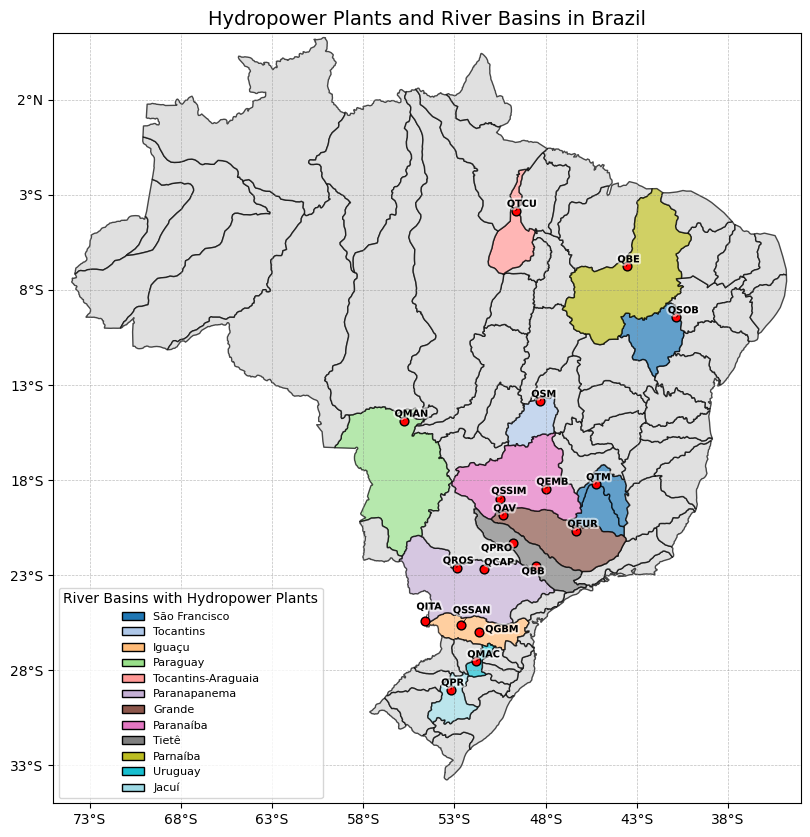

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text  # Biblioteca para evitar sobreposição de labels
import matplotlib.patheffects as path_effects

# ==========================
# Função para formatar coordenadas em graus com N, S, O, E
# # ==========================
# def format_coord(value, _):
#     if value < 0:
#         return f"{abs(value):.0f}°S" if _ == ax.yaxis else f"{abs(value):.0f}°W"
#     else:
#         return f"{value:.0f}°N" if _ == ax.yaxis else f"{value:.0f}°E"


# Definir a formatação das coordenadas (graus com S, N, O, E)
def format_coord(value, pos):
    if pos is None:  # This is a label, not a tick
        return f"{abs(value):.0f}°S" if value < 0 else f"{value:.0f}°N"
    else:  # This is a tick
        if ax.xaxis.get_scale() == 'linear':  # Longitude (x-axis)
            return f"{abs(value):.0f}°W" if value < 0 else f"{value:.0f}°E"
        else:  # Latitude (y-axis)
            return f"{abs(value):.0f}°S" if value < 0 else f"{value:.0f}°N"

# ==========================
# Plotagem do Mapa
# ==========================
fig, ax = plt.subplots(figsize=(12, 10))

# --- Filtrar subbacias que têm interseção com usinas (apenas para a legenda) ---
subbacias_com_usinas = subbacias[subbacias.geometry.intersects(usinas.unary_union)]
subbacias_legenda = subbacias_com_usinas["DNS_NM"].unique()

# --- Criar colormap para as subbacias que têm usinas ---
cmap = plt.cm.get_cmap("tab20", len(subbacias_legenda))
cores_subbacias = {nome: cmap(i) for i, nome in enumerate(subbacias_legenda)}

# Definir cor cinza para subbacias que NÃO possuem usinas
cor_cinza = "#d3d3d3"
subbacias["cor"] = subbacias["DNS_NM"].map(lambda nome: cores_subbacias.get(nome, cor_cinza))

# Plota TODAS as subbacias (as sem usinas ficam cinza)
subbacias.plot(ax=ax, color=subbacias["cor"], edgecolor="black", alpha=0.7)

# Plota as usinas hidrelétricas como pontos vermelhos
usinas.plot(ax=ax, color="red", markersize=40, marker="o", edgecolor="black", label="Hydroelectric Power Plants")

# ==========================
# Ajustar a posição dos labels das usinas
# ==========================
texts = []
for x, y, nome in zip(usinas.geometry.x, usinas.geometry.y, usinas["Empreendim"]):
    text = ax.text(x, y, nome, fontsize=7, fontweight="bold", ha="right", color="black",
                   path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="white", alpha=0.6)])  # Sombra translúcida
    texts.append(text)

# Ajusta automaticamente os labels para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Criar uma legenda APENAS com subbacias que contêm usinas
legend_patches = [Patch(facecolor=cores_subbacias[nome], edgecolor="black", label=nome) for nome in subbacias_legenda]

# ax.legend(handles=legend_patches, title="River Basins with Hydropower Plants", loc="upper left", fontsize=8, title_fontsize=10)
ax.legend(handles=legend_patches, title="River Basins with Hydropower Plants", loc="lower left", fontsize=8, title_fontsize=10)

# ==========================
# Formatar coordenadas
# ==========================
ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.xaxis)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.yaxis)))

# Definir ticks personalizados para latitude e longitude
ax.set_xticks(range(int(subbacias.total_bounds[0]), int(subbacias.total_bounds[2]) + 1, 5))  # Intervalo de 5°
ax.set_yticks(range(int(subbacias.total_bounds[1]), int(subbacias.total_bounds[3]) + 1, 5))  # Intervalo de 5°

# Ajustes no mapa
ax.set_title("Hydropower Plants and River Basins in Brazil", fontsize=14)

# Remover os títulos dos eixos
ax.set_xlabel("")
ax.set_ylabel("")

import matplotlib.ticker as mticker

# Adicionar gridlines (linhas de latitude e longitude)
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)  # Linhas finas tracejadas

# Definir a formatação das coordenadas (graus com S, N, O, E)
def format_coord(value, pos):
    if value < 0:
        return f"{abs(value):.0f}°S" if ax.yaxis.get_scale() == 'linear' else f"{abs(value):.0f}°O"
    else:
        return f"{value:.0f}°N" if ax.yaxis.get_scale() == 'linear' else f"{value:.0f}°E"

# Ajustar labels no eixo X (longitude) e eixo Y (latitude)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_coord))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_coord))

# Definir espaçamento dos ticks (de 5° em 5°)
ax.set_xticks(range(int(subbacias.total_bounds[0]), int(subbacias.total_bounds[2]) + 1, 5))
ax.set_yticks(range(int(subbacias.total_bounds[1]), int(subbacias.total_bounds[3]) + 1, 5))

ax.set_xlim(-75, -34)  # Define os limites de longitude
ax.set_ylim(-35, 5.5)  # Define os limites de latitude


caminho_saida = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras/mapa_usinas1.png"  # Ajuste o caminho e nome do arquivo
plt.savefig(caminho_saida, dpi=300, bbox_inches="tight", transparent=True)


# plt.show()


<ipython-input-54-165df11a081c>:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  subbacias_com_usinas = subbacias[subbacias.geometry.intersects(usinas.unary_union)]
<ipython-input-54-165df11a081c>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(subbacias_legenda))


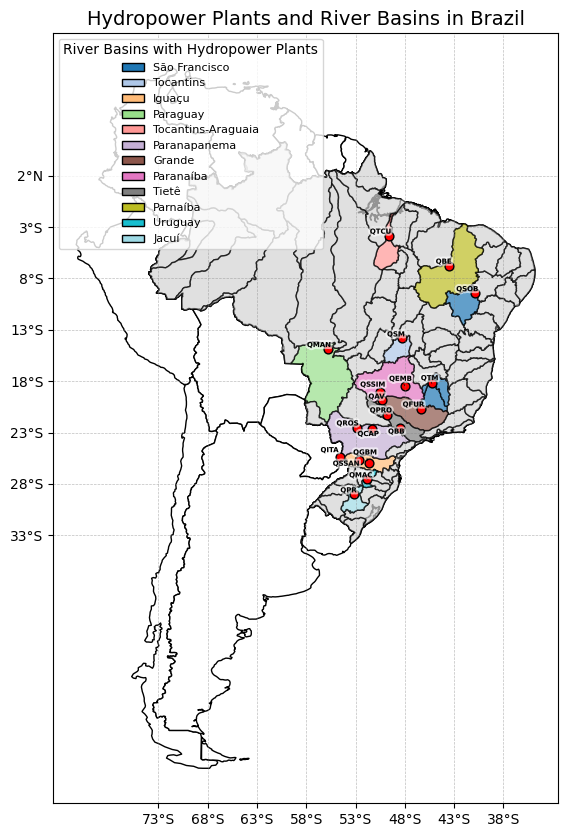

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text  # Biblioteca para evitar sobreposição de labels
import matplotlib.patheffects as path_effects

# ==========================
# Função para formatar coordenadas em graus com N, S, O, E
# ==========================
def format_coord(value, _):
    if value < 0:
        return f"{abs(value):.0f}°S" if _ == ax.yaxis else f"{abs(value):.0f}°W"
    else:
        return f"{value:.0f}°N" if _ == ax.yaxis else f"{value:.0f}°E"

# ==========================
# Carregamento do Shapefile da América do Sul
# ==========================
america = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/America_do_Sul/GEOFT_PAIS.shp")
america = america.to_crs(epsg=4326)

# ==========================
# Definir os limites da região que queremos mostrar (focar no Brasil)
# ==========================
# Coordenadas mais específicas para o Brasil (latitudes e longitudes)
limite_lat_min = -35.0  # Latitude mínima para o Brasil
limite_lat_max = 5.5    # Latitude máxima para o Brasil
limite_lon_min = -75.0  # Longitude mínima para o Brasil
limite_lon_max = -34.0  # Longitude máxima para o Brasil

# ==========================
# Plotagem do Mapa
# ==========================
fig, ax = plt.subplots(figsize=(12, 10))

# --- Recortar a América do Sul para a região do Brasil ---
# Aqui, usamos as coordenadas de recorte para mostrar apenas a parte desejada
america_clip = america.cx[limite_lon_min:limite_lon_max, limite_lat_min:limite_lat_max]

# Plota o shapefile da América do Sul recortado (com fundo branco e contorno preto)
america_clip.plot(ax=ax, color="white", edgecolor="black", linewidth=1)

# --- Filtrar subbacias que têm interseção com usinas (apenas para a legenda) ---
subbacias_com_usinas = subbacias[subbacias.geometry.intersects(usinas.unary_union)]
subbacias_legenda = subbacias_com_usinas["DNS_NM"].unique()

# --- Criar colormap para as subbacias que têm usinas ---
cmap = plt.cm.get_cmap("tab20", len(subbacias_legenda))
cores_subbacias = {nome: cmap(i) for i, nome in enumerate(subbacias_legenda)}

# Definir cor cinza para subbacias que NÃO possuem usinas
cor_cinza = "#d3d3d3"
subbacias["cor"] = subbacias["DNS_NM"].map(lambda nome: cores_subbacias.get(nome, cor_cinza))

# Plota TODAS as subbacias (as sem usinas ficam cinza)
subbacias.plot(ax=ax, color=subbacias["cor"], edgecolor="black", alpha=0.7)

# Plota as usinas hidrelétricas como pontos vermelhos
usinas.plot(ax=ax, color="red", markersize=40, marker="o", edgecolor="black", label="Hydroelectric Power Plants")

# ==========================
# Ajustar a posição dos labels das usinas (com fontes menores)
# ==========================
texts = []
for x, y, nome in zip(usinas.geometry.x, usinas.geometry.y, usinas["Empreendim"]):
    text = ax.text(x, y, nome, fontsize=5, fontweight="bold", ha="right", color="black",  # Reduzi o tamanho da fonte para 5
                   path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="white", alpha=0.6)])  # Sombra translúcida
    texts.append(text)

# Ajusta automaticamente os labels para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Criar uma legenda APENAS com subbacias que contêm usinas
legend_patches = [Patch(facecolor=cores_subbacias[nome], edgecolor="black", label=nome) for nome in subbacias_legenda]

ax.legend(handles=legend_patches, title="River Basins with Hydropower Plants", loc="upper left", fontsize=8, title_fontsize=10)

# ==========================
# Formatar coordenadas
# ==========================
ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.xaxis)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.yaxis)))

# Definir ticks personalizados para latitude e longitude
ax.set_xticks(range(int(subbacias.total_bounds[0]), int(subbacias.total_bounds[2]) + 1, 5))  # Intervalo de 5°
ax.set_yticks(range(int(subbacias.total_bounds[1]), int(subbacias.total_bounds[3]) + 1, 5))  # Intervalo de 5°

# Ajustes no mapa
ax.set_title("Hydropower Plants and River Basins in Brazil", fontsize=14)

# Remover os títulos dos eixos
ax.set_xlabel("")
ax.set_ylabel("")

import matplotlib.ticker as mticker

# Adicionar gridlines (linhas de latitude e longitude)
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)  # Linhas finas tracejadas

# Definir a formatação das coordenadas (graus com S, N, O, E)
def format_coord(value, pos):
    if value < 0:
        return f"{abs(value):.0f}°S" if ax.yaxis.get_scale() == 'linear' else f"{abs(value):.0f}°O"
    else:
        return f"{value:.0f}°N" if ax.yaxis.get_scale() == 'linear' else f"{value:.0f}°E"

# Ajustar labels no eixo X (longitude) e eixo Y (latitude)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_coord))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_coord))

# Definir espaçamento dos ticks (de 5° em 5°)
ax.set_xticks(range(int(subbacias.total_bounds[0]), int(subbacias.total_bounds[2]) + 1, 5))
ax.set_yticks(range(int(subbacias.total_bounds[1]), int(subbacias.total_bounds[3]) + 1, 5))

# Salvar o mapa gerado
caminho_saida = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras/mapa_usinas.png"
plt.savefig(caminho_saida, dpi=300, bbox_inches="tight", transparent=True)

# Exibir o mapa
plt.show()


In [ ]:
# ==========================
# Carregamento do Shapefile das biomas
# ==========================
biomas = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/biomas/lm_bioma_250.shp")
biomas = subbacias.to_crs(epsg=4326)

<ipython-input-58-0e2f0dac7b08>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set3", len(biomas_legenda))
<ipython-input-58-0e2f0dac7b08>:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, nome in zip(biomas.geometry.centroid.x, biomas.geometry.centroid.y, biomas["Bioma"]):


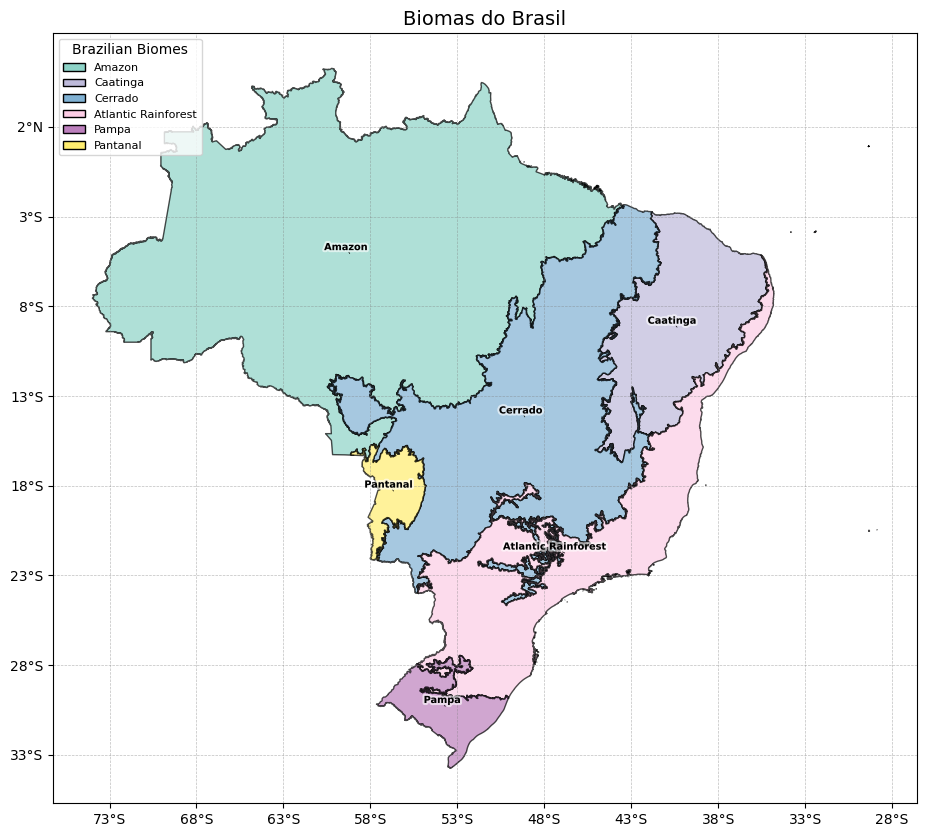

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# ==========================
# Função para formatar coordenadas em graus com N, S, O, E
# ==========================
def format_coord(value, _):
    if value < 0:
        return f"{abs(value):.0f}°S" if _ == ax.yaxis else f"{abs(value):.0f}°W"
    else:
        return f"{value:.0f}°N" if _ == ax.yaxis else f"{value:.0f}°E"

# ==========================
# Carregamento do Shapefile dos Biomas
# ==========================
biomas = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/biomas/lm_bioma_250.shp")
biomas = biomas.to_crs(epsg=4326)

# ==========================
# Criar colormap para os biomas
# ==========================
# Obter lista de biomas únicos
biomas_legenda = biomas["Bioma"].unique()

# Definir uma paleta de cores para os biomas
cmap = plt.cm.get_cmap("Set3", len(biomas_legenda))
cores_biomas = {nome: cmap(i) for i, nome in enumerate(biomas_legenda)}

# Atribuir cor a cada bioma
biomas["cor"] = biomas["Bioma"].map(cores_biomas)

# ==========================
# Plotagem do Mapa
# ==========================
fig, ax = plt.subplots(figsize=(12, 10))

# Plota os biomas com cores atribuídas
biomas.plot(ax=ax, color=biomas["cor"], edgecolor="black", alpha=0.7)

# ==========================
# Ajustar a posição dos labels dos biomas
# ==========================
texts = []
for x, y, nome in zip(biomas.geometry.centroid.x, biomas.geometry.centroid.y, biomas["Bioma"]):
    text = ax.text(x, y, nome, fontsize=7, fontweight="bold", ha="center", color="black",
                   path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="white", alpha=0.6)])  # Sombra translúcida
    texts.append(text)

# Ajusta automaticamente os labels para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# ==========================
# Criar uma legenda com os biomas
# ==========================
legend_patches = [Patch(facecolor=cores_biomas[nome], edgecolor="black", label=nome) for nome in biomas_legenda]

ax.legend(handles=legend_patches, title="Brazilian Biomes", loc="upper left", fontsize=8, title_fontsize=10)

# ==========================
# Formatar coordenadas
# ==========================
ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.xaxis)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.yaxis)))

# Definir ticks personalizados para latitude e longitude
ax.set_xticks(range(int(biomas.total_bounds[0]), int(biomas.total_bounds[2]) + 1, 5))  # Intervalo de 5°
ax.set_yticks(range(int(biomas.total_bounds[1]), int(biomas.total_bounds[3]) + 1, 5))  # Intervalo de 5°

# Ajustes no mapa
ax.set_title("Biomas do Brasil", fontsize=14)

# Remover os títulos dos eixos
ax.set_xlabel("")
ax.set_ylabel("")

import matplotlib.ticker as mticker

# Adicionar gridlines (linhas de latitude e longitude)
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)  # Linhas finas tracejadas

# Definir a formatação das coordenadas (graus com S, N, O, E)
def format_coord(value, pos):
    if value < 0:
        return f"{abs(value):.0f}°S" if ax.yaxis.get_scale() == 'linear' else f"{abs(value):.0f}°O"
    else:
        return f"{value:.0f}°N" if ax.yaxis.get_scale() == 'linear' else f"{value:.0f}°E"

# Ajustar labels no eixo X (longitude) e eixo Y (latitude)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_coord))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_coord))

# Definir espaçamento dos ticks (de 5° em 5°)
ax.set_xticks(range(int(biomas.total_bounds[0]), int(biomas.total_bounds[2]) + 1, 5))
ax.set_yticks(range(int(biomas.total_bounds[1]), int(biomas.total_bounds[3]) + 1, 5))

# Salvar o mapa gerado
caminho_saida = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras/mapa_biomas.png"  # Ajuste o caminho e nome do arquivo
plt.savefig(caminho_saida, dpi=300, bbox_inches="tight", transparent=True)

# Exibir o mapa
plt.show()


<ipython-input-29-c31853dbda03>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Greens", len(biomas_legenda))  # Usando uma paleta de verdes
<ipython-input-29-c31853dbda03>:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, nome in zip(biomas.geometry.centroid.x, biomas.geometry.centroid.y, biomas["Bioma"]):


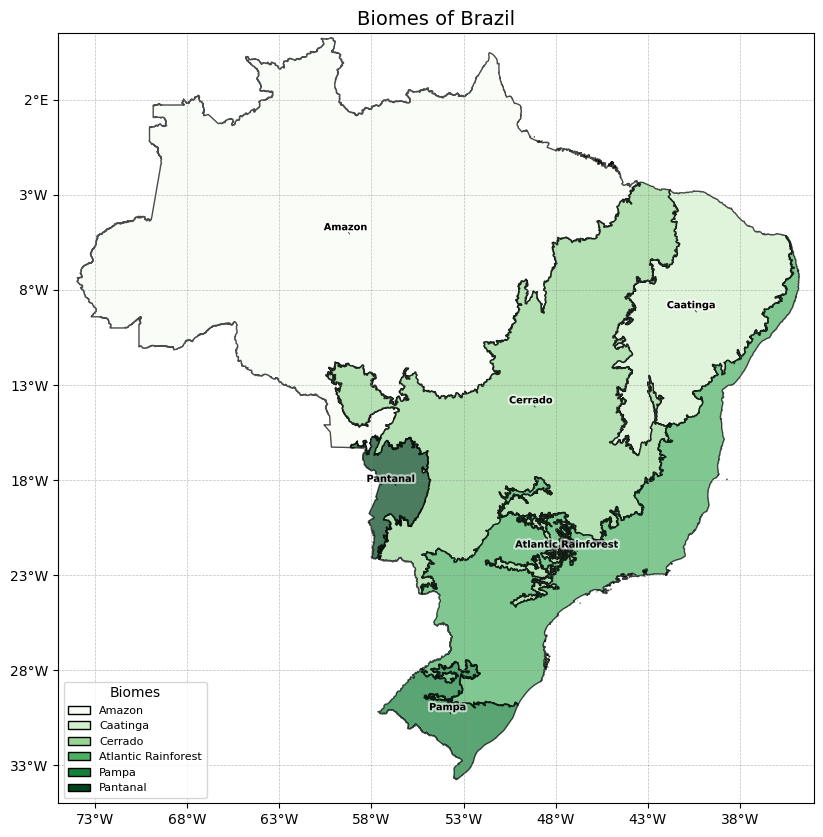

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np

# ==========================
# Função para formatar coordenadas em graus com N, S, O, E
# ==========================
def format_coord(value, _):
    if value < 0:
        return f"{abs(value):.0f}°S" if _ == ax.yaxis else f"{abs(value):.0f}°W"
    else:
        return f"{value:.0f}°N" if _ == ax.yaxis else f"{value:.0f}°E"

# ==========================
# Carregamento do Shapefile dos Biomas
# ==========================
biomas = gpd.read_file("/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/shapes/biomas/lm_bioma_250.shp")
biomas = biomas.to_crs(epsg=4326)

# ==========================
# Criar uma paleta de verdes para os biomas
# ==========================
# Obter lista de biomas únicos
biomas_legenda = biomas["Bioma"].unique()

# Definir uma paleta de verdes
cmap = plt.cm.get_cmap("Greens", len(biomas_legenda))  # Usando uma paleta de verdes
cores_biomas = {nome: cmap(i) for i, nome in enumerate(biomas_legenda)}

# Atribuir cor a cada bioma
biomas["cor"] = biomas["Bioma"].map(cores_biomas)

# ==========================
# Plotagem do Mapa
# ==========================
fig, ax = plt.subplots(figsize=(12, 10))

# Plota os biomas com cores atribuídas
biomas.plot(ax=ax, color=biomas["cor"], edgecolor="black", alpha=0.7)

# ==========================
# Ajustar a posição dos labels dos biomas
# ==========================
texts = []
for x, y, nome in zip(biomas.geometry.centroid.x, biomas.geometry.centroid.y, biomas["Bioma"]):
    text = ax.text(x, y, nome, fontsize=7, fontweight="bold", ha="center", color="black",
                   path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="white", alpha=0.6)])  # Sombra translúcida
    texts.append(text)

# Ajusta automaticamente os labels para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# ==========================
# Criar uma legenda com os biomas
# ==========================
legend_patches = [Patch(facecolor=cores_biomas[nome], edgecolor="black", label=nome) for nome in biomas_legenda]

# ax.legend(handles=legend_patches, title="Biomas do Brasil", loc="upper left", fontsize=8, title_fontsize=10)
ax.legend(handles=legend_patches, title="Biomes", loc="lower left", fontsize=8, title_fontsize=10)

# ==========================
# Formatar coordenadas
# ==========================
ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.xaxis)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: format_coord(val, ax.yaxis)))

# Definir ticks personalizados para latitude e longitude
ax.set_xticks(range(int(biomas.total_bounds[0]), int(biomas.total_bounds[2]) + 1, 5))  # Intervalo de 5°
ax.set_yticks(range(int(biomas.total_bounds[1]), int(biomas.total_bounds[3]) + 1, 5))  # Intervalo de 5°

# Ajustes no mapa
# ax.set_title("Biomas do Brasil", fontsize=14)
ax.set_title("Biomes of Brazil", fontsize=14)


# Remover os títulos dos eixos
ax.set_xlabel("")
ax.set_ylabel("")

import matplotlib.ticker as mticker

# Adicionar gridlines (linhas de latitude e longitude)
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)  # Linhas finas tracejadas

# Definir a formatação das coordenadas (graus com S, N, O, E)
# def format_coord(value, pos):
#     if value < 0:
#         return f"{abs(value):.0f}°S" if ax.yaxis.get_scale() == 'linear' else f"{abs(value):.0f}°O"
#     else:
#         return f"{value:.0f}°N" if ax.yaxis.get_scale() == 'linear' else f"{value:.0f}°E"

# Definir a formatação das coordenadas (graus com S, N, O, E)
def format_coord(value, pos):
    if pos is None:  # This is a label, not a tick
        return f"{abs(value):.0f}°S" if value < 0 else f"{value:.0f}°N"
    else:  # This is a tick
        if ax.xaxis.get_scale() == 'linear':  # Longitude (x-axis)
            return f"{abs(value):.0f}°W" if value < 0 else f"{value:.0f}°E"
        else:  # Latitude (y-axis)
            return f"{abs(value):.0f}°S" if value < 0 else f"{value:.0f}°N"

# Ajustar labels no eixo X (longitude) e eixo Y (latitude)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_coord))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_coord))

# Definir espaçamento dos ticks (de 5° em 5°)
ax.set_xticks(range(int(biomas.total_bounds[0]), int(biomas.total_bounds[2]) + 1, 5))
ax.set_yticks(range(int(biomas.total_bounds[1]), int(biomas.total_bounds[3]) + 1, 5))

ax.set_xlim(-75, -34)  # Define os limites de longitude
ax.set_ylim(-35, 5.5)  # Define os limites de latitude

# Salvar o mapa gerado
caminho_saida = "/content/drive/My Drive/CNPQ_MUD_CLIMA/Artigo_Atmosphere/Figuras/mapa_biomas_verde.png"  # Ajuste o caminho e nome do arquivo
plt.savefig(caminho_saida, dpi=300, bbox_inches="tight", transparent=True)

# # Exibir o mapa
# plt.show()